## Import libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn import tree

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

print('Data has', bike_rentals.shape[0], 'rows and', 
      bike_rentals.shape[1], 'columns')

bike_rentals.head()

Data has 17379 rows and 17 columns


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Specific details on each feature can be found here:

http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

The main target to predict is the *cnt* column, which records the number of bikes rented each row. Each row represents one hour in a single day.

## Basic data exploration

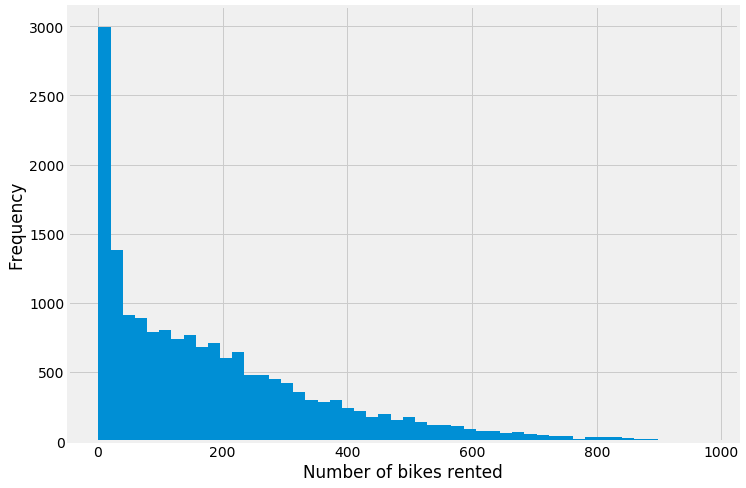

Mode: 5
Median: 142.0
Interquartile Range: 241.0


In [3]:
%matplotlib inline
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')
bike_rentals['cnt'].plot.hist(bins = 50)
plt.xlabel('Number of bikes rented')
plt.show()

print('Mode:',int(stats.mode(bike_rentals['cnt'])[0]))
print('Median:',np.median(bike_rentals['cnt']))
print('Interquartile Range:',stats.iqr(bike_rentals['cnt']))

Most commonly, 5 bikes are rented per hour. There's a big right-skew in the distribution of bikes rented, and the interquartile range (IQR) is very different than the most popular figure of 5 bikes rented per hour. This tells us that there are periods where bike rentals are very popular.

It's also helpful at this point to see which features are correlated with the *cnt* column. **NOTE:** these are absolute correlations.

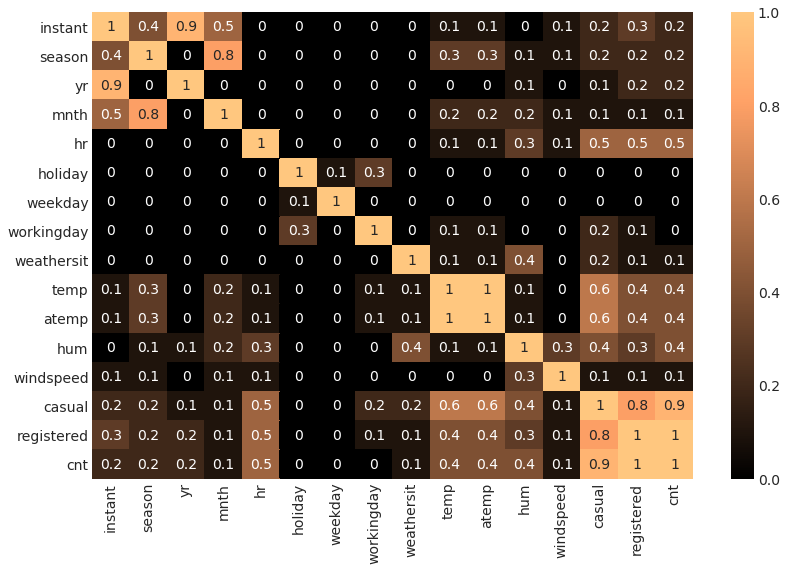

In [4]:
sns.set_style('darkgrid')
plt.figure(figsize = (12,8))
sns.heatmap(np.abs(np.round(bike_rentals.corr(method = 'spearman'),1)),
           annot = True,cmap = 'copper')
plt.show()

From this it's possible to see that *registered* (users) and *casual* (non-registered users) are the most highly correlated with bike rentals. That should be obvious because the total count of bikes rented comes from the sum of those two columns.

Aside from that, there is a medium/large sized positive correlations with *hr*. This is difficult to interpret and will be transformed into categories later.

*atemp* and *temp* are both moderately correlated to bike rentals. This suggests bike rentals are more popular when it's hotter.

Finally, *hum* (humidity) is also moderately correlated with *cnt*. In this instance, the correlation is negative. Less bikes seem to be rented when it's humid.

Below, scatterplots of all columns are plotted against ***cnt***. This will highlight any obvious linear relationships, and show features which might need to be transformed.

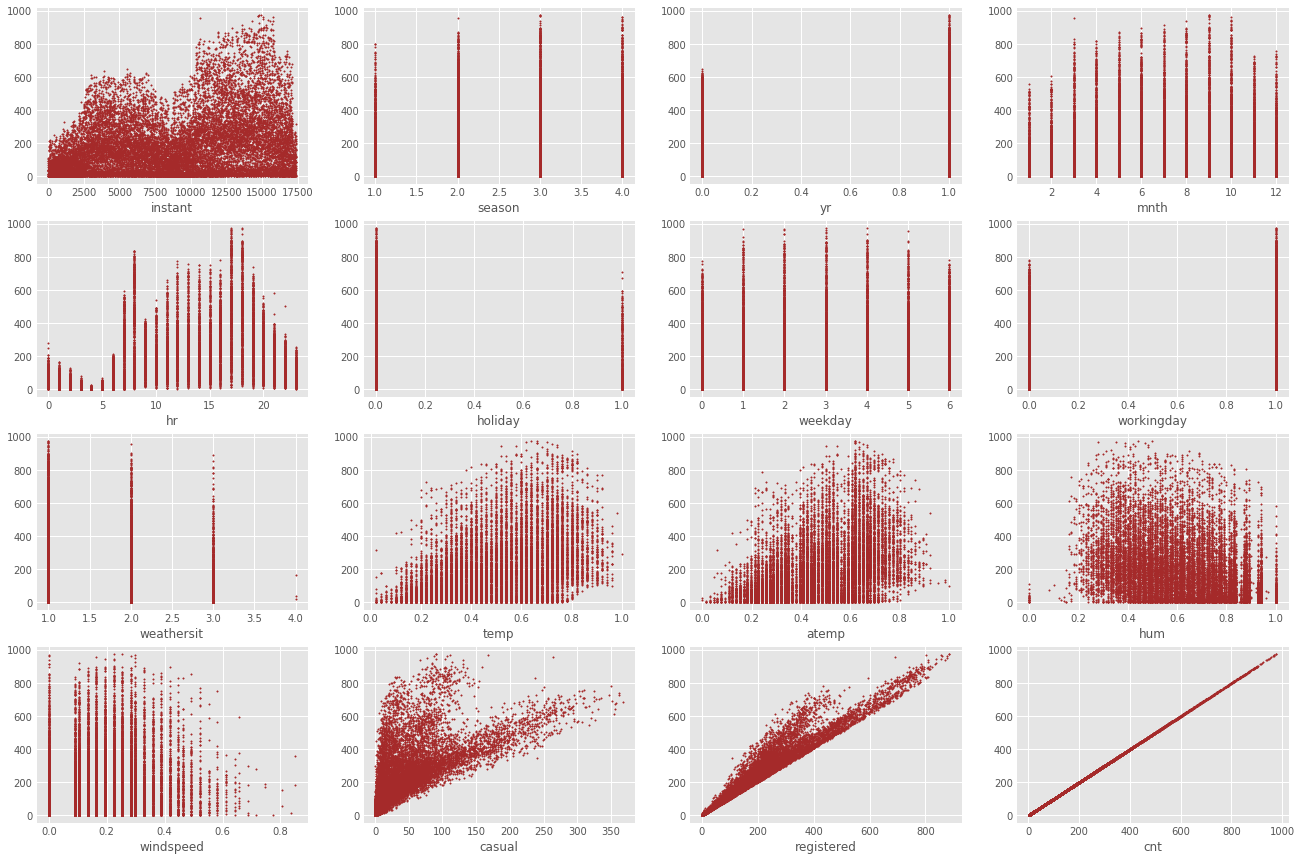

In [5]:
numeric_df = bike_rentals.copy().select_dtypes(['float64','int64'])
columns = numeric_df.columns

sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,14))
plt.style.use('ggplot')
for i in range(len(columns)):
    ax = fig.add_subplot(4,4,i+1)
    plt.scatter(numeric_df[columns[i]], numeric_df['cnt'],
               s = 2, color = 'brown')
    plt.xlabel(columns[i])
plt.show()

## Feature modification (more to modify later)

1. Reclassifying *hr*:
    - 1 if *hr* = 6-12
    - 2 if *hr* = 12-18
    - 3 if *hr* = 18-24
    - 4 if *hr* = 0:6

In [6]:
def convert_hours(num):
    if isinstance(num,int):
        if 6 <= num < 12:
            return 1
        elif 12 <= num < 18:
            return 2
        elif 18 <= num < 24:
            return 3
        else:
            return 4
    else:
        raise TypeError('Conversion character is not an integer')

In [7]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(convert_hours)

## Linear Regression Model

### Removing inappropriate features

In [8]:
# Columns to remove 
remove_cols = ['hr','instant', 'dteday','casual','yr','registered','cnt']

lin_data = bike_rentals.copy()
target = bike_rentals.copy()['cnt']

lin_data.drop(remove_cols, axis = 1, inplace = True)

*Instant* is removed as this is just a row label. *dteday* is removed as it's a date in the past, and future predictions won't have this feature. Also removed are *casual* and *registered* as the sum of the two make up the target variable - *cnt*. The year variable, *yr* is also removed because past years will not be available when making future predictions.

### Removing multi-collinear features

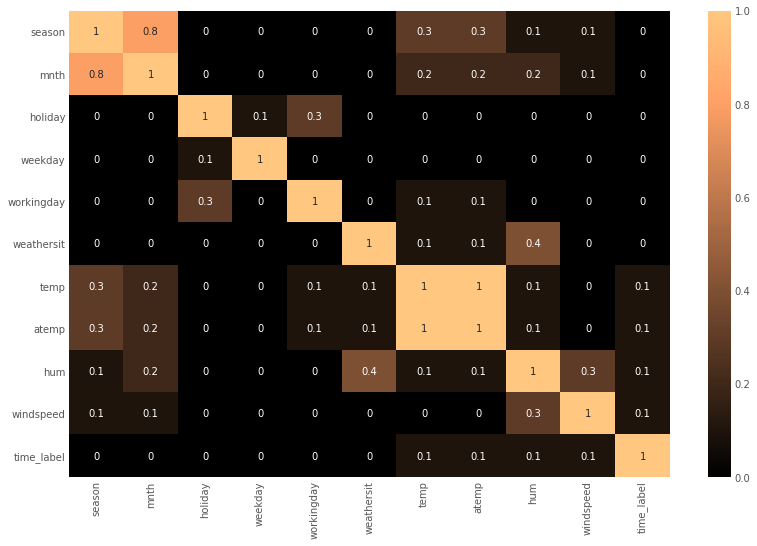

In [9]:
plt.figure(figsize = (12,8))
sns.heatmap(np.abs(np.round(lin_data.corr(method = 'spearman'),1)),
           annot = True,cmap = 'copper')
plt.show()

A quick look at the updated correlation heatmap reveals the columns *mnth* (months, 1-12) and *season* (seasons, 1-4) are correlated with each other. This makes sense. The *mnth* column will provide more information, so *season* is removed.

Secondly, *temp* (temperature) and *atemp* (feel temperature) share a perfect correlation. The model will exclude *atemp* because the *temp* variable is probably more objective.

In [10]:
remove_cols2 = ['season','atemp']
lin_data.drop(remove_cols2,axis=1,inplace=True)

### Dummy coding categorical variables

In [11]:
categorical = ['mnth','holiday','weekday','workingday','weathersit',
              'time_label']

# Creating categories and dummies, and removing original columns
lin_data[categorical] = lin_data[categorical].astype('category')
dummies = pd.get_dummies(lin_data[categorical])

lin_data = pd.concat([lin_data,dummies],axis=1)
lin_data.drop(categorical,axis=1,inplace=True)

### Creating a framework function to simplify model creation

In [12]:
def train_crossval(columns):
    features = lin_data[columns].copy()
    targets = target.copy()
    mse_list = []
    var_list = []
    
    # Initialise K-Fold
    kf = KFold(n_splits=20,shuffle=True,random_state=1)
    
    # Iteratively generate MSE's and the variance of the prediction
    for train_idx, test_idx in kf.split(features):
        x_train, y_train = features.iloc[train_idx], targets.iloc[train_idx]
        x_test, y_test = features.iloc[test_idx], targets.iloc[test_idx]
        
        # Modelling
        model = LinearRegression()
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        # Calculating Error and Prediction Variance
        mse = mean_squared_error(y_pred=predictions,y_true=y_test)
        var = np.var(predictions,ddof=1)
        mse_list.append(mse)
        var_list.append(var)
        
        return np.mean(mse_list), np.mean(var_list)

K Fold cross validation is used to give a better estimate of error we can expect to obtain when applying the model to a previously unseen dataset.

#### Create an empty list for the values of MSE and variance for multiple models

In [13]:
mse_list = []
var_list = []

### Model 1 - Baseline (temp)
 
It seems to make sense to start with *temp*. It seems to have a relatively linear relationship with *cnt*. Check the scatterplots above for this.

In [14]:
mse1, var1 = train_crossval(['temp'])

print('MSE:', mse1, '\nVariance:', var1)

MSE: 28647.233409179476 
Variance: 5516.886629641798


In [15]:
mse_list.append(mse1)
var_list.append(var1)

Look's like using temperature alone, the model is rougly off by 169 counts. This isn't very good.

### Model 2 - temp + time_labels

In [16]:
cols = list(lin_data.filter(regex = ("time_label")))
cols.append('temp')

mse2, var2 = train_crossval(cols)

print('MSE:', mse2, '\nVariance:', var2)

MSE: 20341.217922899887 
Variance: 13368.568436444375


In [17]:
mse_list.append(mse2)
var_list.append(var2)

### Model 3 - temp + time_labels + mnth

In [18]:
cols = list(lin_data.filter(regex = ("time_label|mnth")))
cols.append('temp')

mse3, var3 = train_crossval(cols)

print('MSE:', mse3, '\nVariance:', var3)

MSE: 19936.925095745828 
Variance: 13585.591493545748


In [19]:
mse_list.append(mse3)
var_list.append(var3)

### Model 4 - temp + time_labels + mnth + weather

In [20]:
cols = list(lin_data.filter(regex = ("time_label|mnth|weather")))
cols.append('temp')

mse4, var4 = train_crossval(cols)

print('MSE:', mse4, '\nVariance:', var4)

MSE: 19475.247266973533 
Variance: 14261.064178477964


In [21]:
mse_list.append(mse4)
var_list.append(var4)

### Model 5 - temp + time_labels + mnth + weather + hum

In [22]:
cols = list(lin_data.filter(regex = ("time_label|mnth|weather|working")))
cols.append('temp')

mse5, var5 = train_crossval(cols)

print('MSE:', mse5, '\nVariance:', var5)

MSE: 19442.235543728424 
Variance: 14392.992448382058


In [23]:
mse_list.append(mse5)
var_list.append(var5)

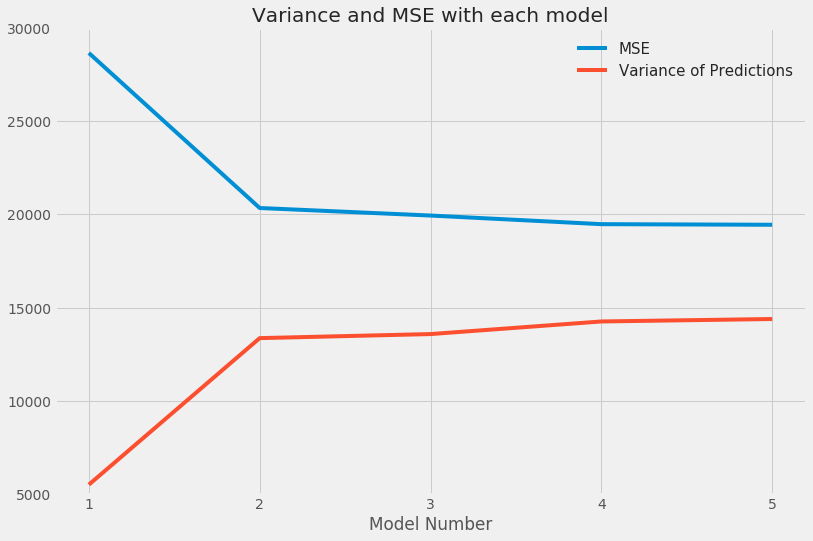

In [24]:
models = list(range(1,6))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (12,8))
plt.plot(models, mse_list, label = 'MSE')
plt.plot(models, var_list, label = 'Variance of Predictions')
plt.xticks(np.arange(1,6))
plt.ylim(5000,3e4)
plt.legend(fontsize = 15)
plt.xlabel('Model Number')
plt.title('Variance and MSE with each model')
plt.show()

In [25]:
rmse_list = np.sqrt(mse_list)

for idx,x in enumerate(rmse_list):
    print('RMSE Model {}:'.format(idx+1), rmse_list[idx])

RMSE Model 1: 169.25493614420668
RMSE Model 2: 142.6226416909317
RMSE Model 3: 141.19817667287998
RMSE Model 4: 139.55374329258794
RMSE Model 5: 139.43541710673233


Adding the *time_label* columns had the greatest benefit on reducing the error of the model from the baseline model. Overall however, linear regression doesn't do a great job at predicting the number of bikes rented. Even the best models are off by around ~140 bikes. 

The MSE remains consistently high because there are large variations in *cnt* as seen in the IQR above. This means predictions that are wrong by a lot get penalized greatly, increasing the MSE value.

If a model had to be chosen, model 2 is probably the one to pick (*temp* + *time_label*). It represents the best tradeoff between bias and variance.

## Decision Tree Regression

### Removing inappropriate features

In [26]:
remove_cols = ['time_label','instant', 'dteday','casual','yr','registered','cnt']
dec_data = bike_rentals.copy().drop(remove_cols,axis=1)
targets = target

### Creating a framework function to simplify model creation

In [27]:
def train_crossval2(dec_data,targets,min_leaf=1,min_s_split=2,depth=None,
                   method = 'best'):
    mse_list = []
    var_list = []

    kf = KFold(n_splits=20,shuffle=True,random_state=1)

    # Iteratively generate MSE's and variance of the prediction
    for train_idx, test_idx in kf.split(dec_data):
        x_train, y_train = dec_data.iloc[train_idx], targets.iloc[train_idx]
        x_test, y_test = dec_data.iloc[test_idx], targets.iloc[test_idx]
    
        # Modelling
        model = DecisionTreeRegressor(random_state = 1, min_samples_leaf=min_leaf,
                                     min_samples_split=min_s_split,
                                     max_depth=depth,
                                     splitter = method)
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)

        # Calculating Error and Prediction Variance
        mse = mean_squared_error(y_pred=predictions,y_true=y_test)
        var = np.var(predictions,ddof=1)
        mse_list.append(mse)
        var_list.append(var)
    
    model.fit(dec_data,targets)
    predictions = model.predict(dec_data) 
    
    return np.mean(mse_list), np.mean(var_list), model, predictions

#### Create an empty list for the values of MSE and variance for multiple models

In [28]:
mse_list = []
var_list = []

### Model 1 - Fitting a baseline decision tree

In [29]:
mse1, var1, model1, pred1 = train_crossval2(dec_data,targets)

In [30]:
mse_list.append(mse1)
var_list.append(var1)

In [31]:
print('MSE:',mse1,'\nVariance:',var1)

MSE: 7705.121888804337 
Variance: 32773.72861412851


Using a decision tree regression model has brought down the MSE significantly compared to a linear regression approach. However, note that the variance has increased a lot. This suggests that the model suffers from overfitting. It probably does well on the data that it was given, but won't generalise well across to unseen data. One way to improve this is by limiting the depth of the tree while it is being built. For example, it is possible to set a  limit as to how deep a tree can go, or set a minimum number of data points for a leaf. This makes the model more general. It increases the bias of the model, while reducing the variance. For decision trees, this is highly desirable as they are susceptible to overfitting the data.

### Model 2 - increasing the minimum requirement of datapoints for a leaf

In [32]:
mse2, var2, model2, pred2 = train_crossval2(dec_data,targets,min_leaf = 13)

In [33]:
mse_list.append(mse2)
var_list.append(var2)

In [34]:
print('MSE:',mse2,'\nVariance:',var2)

MSE: 5689.344262119392 
Variance: 28853.639029691956


Looks like simply increasing the minimum number of data points for there to be a leaf decreases error and variance. 

### Model 3 - Random Forests, bagging and random feature selection

In [35]:
model = RandomForestRegressor(n_estimators = 200, n_jobs = 8,
                              min_samples_leaf=13, bootstrap = True,
                             random_state=1)
model.fit(dec_data,targets)
predictions = model.predict(dec_data)

mse3 = mean_squared_error(predictions,targets)
var3 = np.var(predictions)

print('MSE:',mse3,'\nVariance:',var3)

MSE: 3803.4888614647066 
Variance: 27482.716526940658


In [36]:
mse_list.append(mse3)
var_list.append(var3)

Using a random forest approach further decreased the MSE and the variance of predictions. As it uses a bagging approach, there isn't any need to perform cross validation here. Ensembling is done when random forests is used, which helps make more accurate predictions. Below is a graph comparing the MSE and variance of each model.

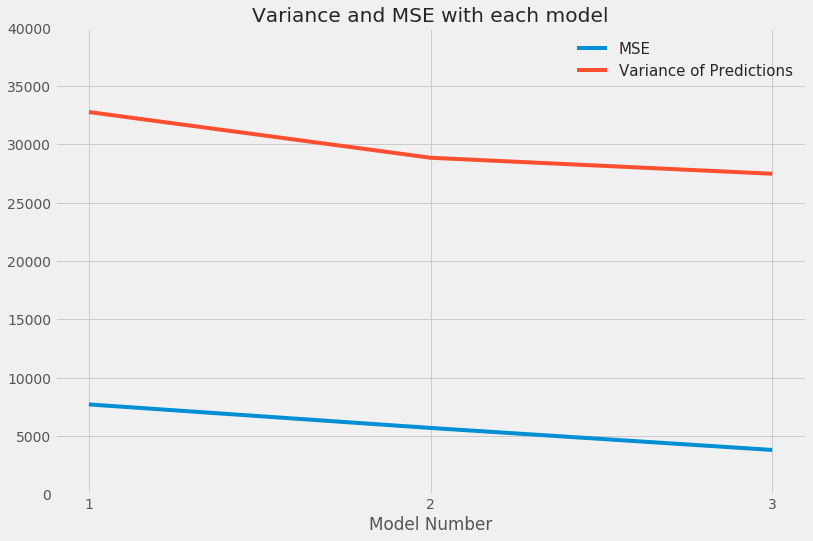

In [37]:
models = list(range(1,4))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (12,8))
plt.plot(models, mse_list, label = 'MSE')
plt.plot(models, var_list, label = 'Variance of Predictions')
plt.xticks(np.arange(1,4))
plt.ylim(0,4e4)
plt.legend(fontsize = 15)
plt.xlabel('Model Number')
plt.title('Variance and MSE with each model')
plt.show()

### Let's compare the first few predictions with actual values (model 3)

In [38]:
head_predict = pd.Series(predictions).head()
actual = targets.head()

for i in range(len(head_predict)):
    print('Actual number of bikes rented at this hour: {} ,'.format(actual[i]),
         'Predicted: {}'.format(head_predict[i]))

print('\nRMSE: {}'.format(np.sqrt(mse_list[2])))

Actual number of bikes rented at this hour: 16 , Predicted: 40.78066443588514
Actual number of bikes rented at this hour: 40 , Predicted: 33.95418614979981
Actual number of bikes rented at this hour: 32 , Predicted: 24.62568799818534
Actual number of bikes rented at this hour: 13 , Predicted: 11.771124033618669
Actual number of bikes rented at this hour: 1 , Predicted: 4.921165226751366

RMSE: 61.672431940573794


Not too bad! The prediction has improved by twofold from the linear regression model. Further tweaking of the parameters could probably increase the accuracy further.

Trees can also be visualised. Model 3 is too large to visualise, so below is an example diagram. **NOTE:** The diagram is not the actual model used - it's much smaller and to be used for illustrative purposes only.

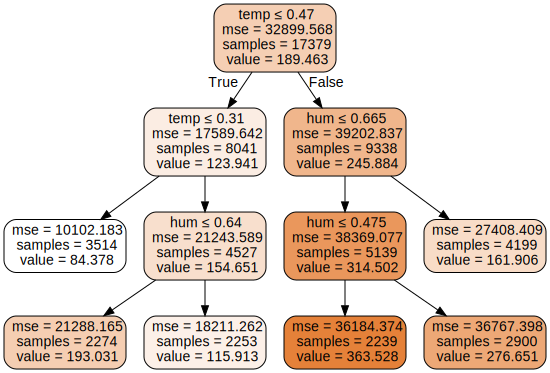

In [39]:
simple_model = DecisionTreeRegressor(random_state = 1, min_samples_leaf=30,
                                     max_depth=7,max_leaf_nodes =6)
simple_model.fit(dec_data[['temp','hum']], targets)

dot_data = tree.export_graphviz(simple_model, out_file=None, 
                         feature_names=dec_data[['temp','hum']].columns,  
                         class_names='Cnt',  
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)  